## 从csv导入数据
导入`unicodecsv`包和其中的`DictDeader`函数将每一行连同列标签变成一个字典，形成一个迭代器；

利用`with...as`来完成自动打开与关闭文件的操作；

将迭代器变为列表。

由于同时读取3个文件的过程是重复的，所以我们将它编写成为一个函数予以更好地调用和修改。

In [1]:
import unicodecsv

def read_csv(filename):
    with open(filename, 'rb') as f:
        reader = unicodecsv.DictReader(f)
        return list(reader)

enrollments = read_csv('enrollments.csv')
daily_engagement = read_csv('daily_engagement.csv')
project_submissions = read_csv('project_submissions.csv')

print(enrollments[0])
print(daily_engagement[0])
print(project_submissions[0])

OrderedDict([('account_key', '448'), ('status', 'canceled'), ('join_date', '2014-11-10'), ('cancel_date', '2015-01-14'), ('days_to_cancel', '65'), ('is_udacity', 'True'), ('is_canceled', 'True')])
OrderedDict([('acct', '0'), ('utc_date', '2015-01-09'), ('num_courses_visited', '1.0'), ('total_minutes_visited', '11.6793745'), ('lessons_completed', '0.0'), ('projects_completed', '0.0')])
OrderedDict([('creation_date', '2015-01-14'), ('completion_date', '2015-01-16'), ('assigned_rating', 'UNGRADED'), ('account_key', '256'), ('lesson_key', '3176718735'), ('processing_state', 'EVALUATED')])


## 修正数据
将字符型数据转换成整数、浮点数、日期或布尔值。

In [2]:
# 修正数据格式
from datetime import datetime as dt

# 将字符串格式的时间转为 Python datetime 类型的时间。
# 如果没有时间字符串传入，返回 None
def parse_date(date):
    if date == '':
        return None
    else:
        return dt.strptime(date, '%Y-%m-%d')
    
# 将可能是空字符串或字符串类型的数据转为 整型 或 None。
def parse_maybe_int(i):
    if i == '':
        return None
    else:
        return int(i)

# 清理 enrollments 数据
for enrollment in enrollments:
    enrollment['cancel_date'] = parse_date(enrollment['cancel_date'])
    enrollment['days_to_cancel'] = parse_maybe_int(enrollment['days_to_cancel'])
    enrollment['is_canceled'] = enrollment['is_canceled'] == 'True'
    enrollment['is_udacity'] = enrollment['is_udacity'] == 'True'
    enrollment['join_date'] = parse_date(enrollment['join_date'])

In [3]:
# 查看修正后的数据
print(enrollments[0])
print(daily_engagement[0])
print(project_submissions[0])

OrderedDict([('account_key', '448'), ('status', 'canceled'), ('join_date', datetime.datetime(2014, 11, 10, 0, 0)), ('cancel_date', datetime.datetime(2015, 1, 14, 0, 0)), ('days_to_cancel', 65), ('is_udacity', True), ('is_canceled', True)])
OrderedDict([('acct', '0'), ('utc_date', '2015-01-09'), ('num_courses_visited', '1.0'), ('total_minutes_visited', '11.6793745'), ('lessons_completed', '0.0'), ('projects_completed', '0.0')])
OrderedDict([('creation_date', '2015-01-14'), ('completion_date', '2015-01-16'), ('assigned_rating', 'UNGRADED'), ('account_key', '256'), ('lesson_key', '3176718735'), ('processing_state', 'EVALUATED')])


In [4]:
# 清洗 daily_engagement 数据
for engagement_record in daily_engagement:
    engagement_record['lessons_completed'] = int(float(engagement_record['lessons_completed']))
    engagement_record['num_courses_visited'] = int(float(engagement_record['num_courses_visited']))
    engagement_record['projects_completed'] = int(float(engagement_record['projects_completed']))
    engagement_record['total_minutes_visited'] = float(engagement_record['total_minutes_visited'])
    engagement_record['utc_date'] = parse_date(engagement_record['utc_date'])

print(daily_engagement[0])

OrderedDict([('acct', '0'), ('utc_date', datetime.datetime(2015, 1, 9, 0, 0)), ('num_courses_visited', 1), ('total_minutes_visited', 11.6793745), ('lessons_completed', 0), ('projects_completed', 0)])


In [5]:
# 清理 submissions 的数据类型
for submission in project_submissions:
    submission['completion_date'] = parse_date(submission['completion_date'])
    submission['creation_date'] = parse_date(submission['creation_date'])

print(project_submissions[0])

OrderedDict([('creation_date', datetime.datetime(2015, 1, 14, 0, 0)), ('completion_date', datetime.datetime(2015, 1, 16, 0, 0)), ('assigned_rating', 'UNGRADED'), ('account_key', '256'), ('lesson_key', '3176718735'), ('processing_state', 'EVALUATED')])


## 调查数据
我们一共有3个数据集，观察每一个中有多少个不同的数据，并创建相应的集合。

In [6]:
# engagement 数据集中列名称与其他两张表不一样, 首先将其变成一样的
# 这样有利于调差数据时，用一个函数写
for engagement_record in daily_engagement:
    engagement_record['account_key'] = engagement_record['acct']
    del engagement_record['acct']

In [7]:
# 调查数据，观察每一个中有多少个不同的数据的函数
def get_unique_students(data):
    unique_students = set()
    for data_point in data:
        unique_students.add(data_point['account_key'])
    # 因为这个集合之后还有用处，所以返回这个集合变量
    return unique_students

In [8]:
# enrollments 数据集
# 去重前的数量
print(len(enrollments))

unique_enrolled_students = get_unique_students(enrollments)
# 去重后的数量
print(len(unique_enrolled_students))

1640
1302


In [9]:
# daily_engagement 数据集
# 去重前的数量
print(len(daily_engagement))

unique_engagement_students = get_unique_students(daily_engagement)
# 去重后的数量
print(len(unique_engagement_students))

136240
1237


In [10]:
# project_submissions 数据集
# 去重前的数量
print(len(project_submissions))

unique_project_submitters = get_unique_students(project_submissions)
# 去重后的数量
print(len(unique_project_submitters))

3642
743


## 分析问题1: 为什么参与数比注册数少？
我们可以找出一个不在参与数据集中的注册数据来分析

In [11]:
for enrollment in enrollments:
    student = enrollment['account_key']
    if student not in unique_engagement_students:
        print(enrollment)
        break

OrderedDict([('account_key', '1219'), ('status', 'canceled'), ('join_date', datetime.datetime(2014, 11, 12, 0, 0)), ('cancel_date', datetime.datetime(2014, 11, 12, 0, 0)), ('days_to_cancel', 0), ('is_udacity', False), ('is_canceled', True)])


从以上一则异常数据中，可以发现`'join_date'`和`'cancel_date'`是同一天，`'days_to_cancel'=0`，也就是说，学生注册后，如果在当天就注销账号，学生是不会被记录的学生需要观看至少1天，才会记录到**参与数据集**中。

但是，下一个问题出现了：是否这能解释所有不在**参与数据集**中的**注册数据**？

我们通过以下来检测：

In [12]:
num_problem_students = 0
for enrollment in enrollments:
    student = enrollment['account_key']
    if student not in unique_engagement_students and enrollment['join_date'] != enrollment['cancel_date']:
        print(enrollment)
        num_problem_students += 1

num_problem_students

OrderedDict([('account_key', '1304'), ('status', 'canceled'), ('join_date', datetime.datetime(2015, 1, 10, 0, 0)), ('cancel_date', datetime.datetime(2015, 3, 10, 0, 0)), ('days_to_cancel', 59), ('is_udacity', True), ('is_canceled', True)])
OrderedDict([('account_key', '1304'), ('status', 'canceled'), ('join_date', datetime.datetime(2015, 3, 10, 0, 0)), ('cancel_date', datetime.datetime(2015, 6, 17, 0, 0)), ('days_to_cancel', 99), ('is_udacity', True), ('is_canceled', True)])
OrderedDict([('account_key', '1101'), ('status', 'current'), ('join_date', datetime.datetime(2015, 2, 25, 0, 0)), ('cancel_date', None), ('days_to_cancel', None), ('is_udacity', True), ('is_canceled', False)])


3

从以上结果中，我们发现`'is_udacity'`这一项是`True`，意即udacity的测试号，所以在经过核实后，我们得到结论测试号也会导致不被记录。接下来我们考虑：

1. 为所有 Udacity 测试帐号建立一组 set；
2. 通过 account_key 删除所有 Udacity 的测试帐号；
3. 从3张表中移除所有 Udacity 的测试帐号

In [13]:
# 从enrollments数据集中，为所有 Udacity 测试帐号建立一组 set
udacity_test_accounts = set()
for enrollment_record in enrollments:
    if enrollment_record['is_udacity']:
        udacity_test_accounts.add(enrollment_record['account_key'])
len(udacity_test_accounts)

6

In [14]:
# 通过 account_key 删除所有 Udacity 的测试帐号
def remove_udacity_account(data):
    non_udacity_data = []
    for data_record in data:
        if data_record['account_key'] not in udacity_test_accounts:
            non_udacity_data.append(data_record)
    return non_udacity_data

In [15]:
# 从3张表中移除所有 Udacity 的测试帐号
non_udacity_enrollments = remove_udacity_account(enrollments)
non_udacity_engagement = remove_udacity_account(daily_engagement)
non_udacity_submissions = remove_udacity_account(project_submissions)

print(len(non_udacity_enrollments))
print(len(non_udacity_engagement))
print(len(non_udacity_submissions))

1622
135656
3634


## 分析问题2：对于是否通过首个项目的学生，他们在每日参与表中的数据有何不同
**problems:**

1. This will include from after the project submission.
2. This compares data from different length of time.
3. Includes engagement in courses not related to the first project.

Revision for first two problems: Only look at engagement from first week, and exclude students who cancelled within first week. That way I'll be comparing equal amounts of time. This will also have the benefit of excluding people who cancelled during the free trial which was 7 days at the time the data was collected.

**Step1: Create a dictionary of students who either (paid):**

- haven't cancelled yet: `'is_canceled' is None` 
- stayed enrolled more than 7 days: `'days_to_cancel' > 7`

**Dictonary name**: `paid_students`

**Keys**: `'account_key'` **Values**:`'enrollment_date'`

So how many students are in the dictionary?

In [16]:
paid_students = {}

for enrollment in non_udacity_enrollments:
    if not enrollment['is_canceled'] or enrollment['days_to_cancel'] > 7:
        account_key = enrollment['account_key']
        enrollment_date = enrollment['join_date']
        # same students can enroll multiple times and it makes sense to save their most recent enrollment in this case.
        # it won't change the number of paid students but will change some enrollment date.
        if account_key not in paid_students or enrollment_date > paid_students[account_key]:
            paid_students[account_key] = enrollment_date
len(paid_students)

995

## 获取第1周的数据

In [17]:
# 基于学生的注册日期和参与日期，若该参与活动发生在学生加入1周内，则反回 True

def within_one_week(join_date, engagement_date):
    time_delta = engagement_date - join_date
    return time_delta.days < 7 and time_delta.days >= 0

In [18]:
# 在上面，我们已经从3张表中移除所有 Udacity 的测试帐号，也有了付费学生的集合。
# 此函数将data表中，返回表中付费学生。
def remove_free_trial_cancels(data):
    new_data = []
    for data_record in data:
        if data_record['account_key'] in paid_students:
            new_data.append(data_record)
    return new_data

# 从 非测试账号表 生成 付费表
paid_enrollments = remove_free_trial_cancels(non_udacity_enrollments)
paid_engagement = remove_free_trial_cancels(non_udacity_engagement)
paid_submissions = remove_free_trial_cancels(non_udacity_submissions)

# 查看 付费表 中学生数
print(len(paid_enrollments))
print(len(paid_engagement))
print(len(paid_submissions))

1293
134549
3618


### 此项为后来需要分析第一周访问数而添加的
即第一周的学生上课天数。

In [19]:
# 运行此代码来创建 has_visited 字段
for engagement_record in paid_engagement:
    if engagement_record['num_courses_visited'] > 0:
        engagement_record['has_visited'] = 1
    else:
        engagement_record['has_visited'] = 0

In [20]:
## 创建一个 engagement 记录的列表，该列表只包括付费学生以及加入的前7天的学生的记录
## 输入符合要求的行数
paid_engagement_in_first_week = []

for engagement_record in paid_engagement:
    account_key = engagement_record['account_key']
    # 从 paid_students 表中获取注册日期
    join_date = paid_students[account_key]
    engagement_date = engagement_record['utc_date']
    
    # 这里是利用判断是否是7天内的记录来生成7天学生记录表
    if within_one_week(join_date, engagement_date):
        paid_engagement_in_first_week.append(engagement_record)

# 从而得到付费学生以及加入的前7天学生的学生的记录
print(len(paid_engagement_in_first_week))    

6919


## 探索学生参与度

In [21]:
from collections import defaultdict

# 创建基于 student 对 engagement 进行分组的字典，字典的键为帐号（account key），值为包含互动记录的列表
engagement_by_account = defaultdict(list)
for engagement_record in paid_engagement_in_first_week:
    account_key = engagement_record['account_key']
    engagement_by_account[account_key].append(engagement_record)

In [22]:
# 创建一个包含学生在第1周在教室所花总时间和字典。键为帐号（account key），值为数字（所花总时间）
total_minutes_by_account = {}
for account_key, engagement_for_student in engagement_by_account.items():
    total_minutes = 0
    for engagement_record in engagement_for_student:
        total_minutes += engagement_record['total_minutes_visited']
    total_minutes_by_account[account_key] = total_minutes

In [23]:
import numpy as np

# 汇总和描述关于教室所花时间的数据
# 注意这里将字典的values转换为list: list(dict.values())
total_minutes = list(total_minutes_by_account.values())
print('Mean:', np.mean(total_minutes))
print('Standard deviation:', np.std(total_minutes))
print('Minimum:', np.min(total_minutes))
print('Maximum:', np.max(total_minutes))

Mean: 306.70832675342825
Standard deviation: 412.99693340852957
Minimum: 0.0
Maximum: 3564.7332644989997


In [24]:
# 找到最大学习分钟数的学生
student_with_max_minutes = None
max_minutes = 0

for student, total_minutes in total_minutes_by_account.items():
    if total_minutes > max_minutes:
        max_minutes = total_minutes
        student_with_max_minutes = student

print(student_with_max_minutes)
print(max_minutes)

163
3564.7332644989997


In [25]:
# 打印出这个学生的每个参与记录
for engagement_record in paid_engagement_in_first_week:
    if engagement_record['account_key'] == student_with_max_minutes:
        print(engagement_record)

OrderedDict([('utc_date', datetime.datetime(2015, 7, 9, 0, 0)), ('num_courses_visited', 4), ('total_minutes_visited', 850.519339666), ('lessons_completed', 4), ('projects_completed', 0), ('account_key', '163'), ('has_visited', 1)])
OrderedDict([('utc_date', datetime.datetime(2015, 7, 10, 0, 0)), ('num_courses_visited', 6), ('total_minutes_visited', 872.633923334), ('lessons_completed', 6), ('projects_completed', 0), ('account_key', '163'), ('has_visited', 1)])
OrderedDict([('utc_date', datetime.datetime(2015, 7, 11, 0, 0)), ('num_courses_visited', 2), ('total_minutes_visited', 777.018903666), ('lessons_completed', 6), ('projects_completed', 0), ('account_key', '163'), ('has_visited', 1)])
OrderedDict([('utc_date', datetime.datetime(2015, 7, 12, 0, 0)), ('num_courses_visited', 1), ('total_minutes_visited', 294.568774), ('lessons_completed', 2), ('projects_completed', 0), ('account_key', '163'), ('has_visited', 1)])
OrderedDict([('utc_date', datetime.datetime(2015, 7, 13, 0, 0)), ('num_c

## 第一周完成的课程分钟数

In [27]:
# 将给定代码重构为以下代码，用以分析学员在第一周总共学习的分钟数：
from collections import defaultdict

def group_data(data, key_name):
    grouped_data = defaultdict(list)
    for data_point in data:
        key = data_point[key_name]
        grouped_data[key].append(data_point)
    return grouped_data

engagement_by_account = group_data(paid_engagement_in_first_week,
                                   'account_key')

def sum_grouped_items(grouped_data, field_name):
    summed_data = {}
    for key, data_points in grouped_data.items():
        total = 0
        for data_point in data_points:
            total += data_point[field_name]
        summed_data[key] = total
    return summed_data

total_minutes_by_account = sum_grouped_items(engagement_by_account, 'total_minutes_visited')

Populating the interactive namespace from numpy and matplotlib
Mean: 306.70832675342825
Standard deviation: 412.99693340852957
Minimum: 0.0
Maximum: 3564.7332644989997


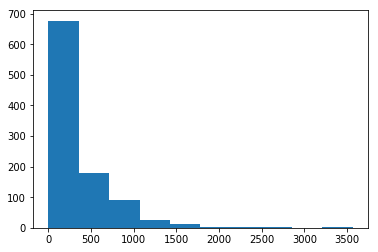

In [28]:
%pylab inline

import matplotlib.pyplot as plt
import numpy as np

# Summarize the given data
def describe_data(data):
    data_list = list(data)
    print('Mean:', np.mean(data_list))
    print('Standard deviation:', np.std(data_list))
    print('Minimum:', np.min(data_list))
    print('Maximum:', np.max(data_list))
    plt.hist(data_list)

describe_data(total_minutes_by_account.values())

可以发现以上结果和之前分析的结果是一样的。

这种方法的好处是可以通过我们针对要分析的标签的名称，来改变函数的参数，以达到目的。比如，我们将`'total_minutes_visited'`改变为`'lessons_completed'`，就能分析参与的课程数了。

## 第一周参与的课程数

Mean: 1.636180904522613
Standard deviation: 3.002561299829423
Minimum: 0
Maximum: 36


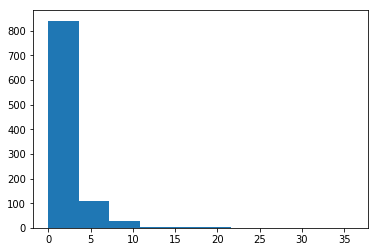

In [29]:
lessons_completed_by_account = sum_grouped_items(engagement_by_account,
                                                 'lessons_completed')
describe_data(lessons_completed_by_account.values())

## 第一周的访问数
即第一周上了几天课。

使用更新的数据重新创建 engagement_by_account 字典后，她运行以下代码来分析第一周的访问日：

Mean: 2.8673366834170855
Standard deviation: 2.2551980029196814
Minimum: 0
Maximum: 7


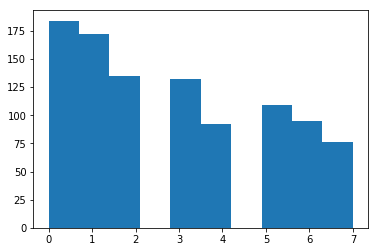

In [30]:
days_visited_by_account = sum_grouped_items(engagement_by_account,
                                            'has_visited')
describe_data(days_visited_by_account.values())

## 划分及格学员

In [31]:
subway_project_lesson_keys = ['746169184', '3176718735']

pass_subway_project = set()

for submission in paid_submissions:
    project = submission['lesson_key']
    rating = submission['assigned_rating']    

    if ((project in subway_project_lesson_keys) and
            (rating == 'PASSED' or rating == 'DISTINCTION')):
        pass_subway_project.add(submission['account_key'])

print(len(pass_subway_project))

passing_engagement = []
non_passing_engagement = []

for engagement_record in paid_engagement_in_first_week:
    if engagement_record['account_key'] in pass_subway_project:
        passing_engagement.append(engagement_record)
    else:
        non_passing_engagement.append(engagement_record)

print(len(passing_engagement))
print(len(non_passing_engagement))

647
4527
2392


## 比较两组学员
通过和未通过的。

As for total minutes
non-passing students:
Mean: 143.32647426675584
Standard deviation: 269.5386190114951
Minimum: 0.0
Maximum: 1768.5227493319999


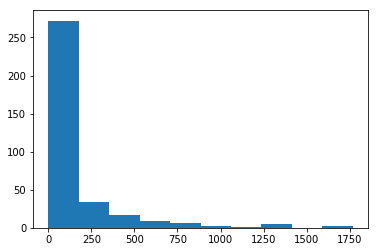

In [32]:
passing_engagement_by_account = group_data(passing_engagement,
                                           'account_key')
non_passing_engagement_by_account = group_data(non_passing_engagement,
                                               'account_key')
print('As for total minutes')
print('non-passing students:')
non_passing_minutes = sum_grouped_items(
    non_passing_engagement_by_account,
    'total_minutes_visited'
)
describe_data(non_passing_minutes.values())

passing students:
Mean: 394.58604648350865
Standard deviation: 448.4995193265521
Minimum: 0.0
Maximum: 3564.7332644989997


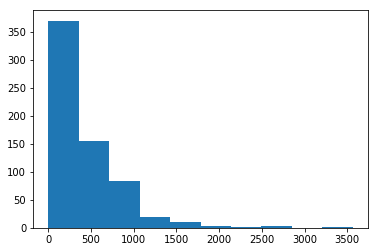

In [33]:
print('passing students:')
passing_minutes = sum_grouped_items(
    passing_engagement_by_account,
    'total_minutes_visited'
)
describe_data(passing_minutes.values())

As for lessions completed
non-passing students:
Mean: 0.8620689655172413
Standard deviation: 2.5491599418312028
Minimum: 0
Maximum: 27


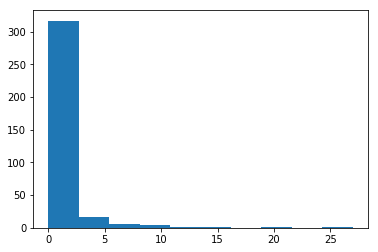

In [34]:
print('As for lessions completed')
print('non-passing students:')
non_passing_lessons = sum_grouped_items(
    non_passing_engagement_by_account,
    'lessons_completed'
)
describe_data(non_passing_lessons.values())

passing students:
Mean: 2.052550231839258
Standard deviation: 3.1422270555779344
Minimum: 0
Maximum: 36


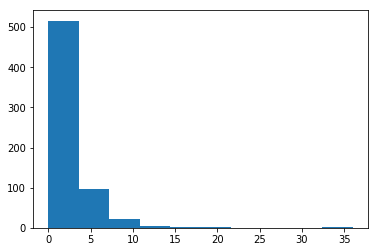

In [35]:
print('passing students:')
passing_lessons = sum_grouped_items(
    passing_engagement_by_account,
    'lessons_completed'
)
describe_data(passing_lessons.values())

As for visited days
non-passing students:
Mean: 1.9051724137931034
Standard deviation: 1.9057314413619046
Minimum: 0
Maximum: 7


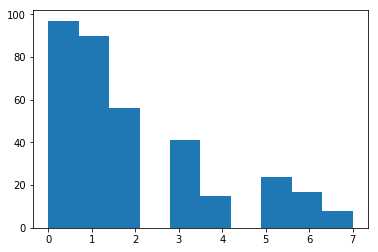

In [36]:
print('As for visited days')
print('non-passing students:')
non_passing_visits = sum_grouped_items(
    non_passing_engagement_by_account, 
    'has_visited'
)
describe_data(non_passing_visits.values())

passing students:
Mean: 3.384853168469861
Standard deviation: 2.2588214709184595
Minimum: 0
Maximum: 7


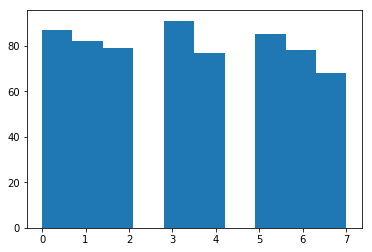

In [37]:
print('passing students:')
passing_visits = sum_grouped_items(
    passing_engagement_by_account,
    'has_visited'
)
describe_data(passing_visits.values())

## 得到结论与分析

现在轮到我们**得出结论**或者**进行预测**，你可能已经得出了一些初步结论，例如**通过地铁项目的学生在第一周中上课的分钟数要大于未通过的学生**，但是即便通过和未通过项目的学生之间不存任何实际差异，两组的平均值也不会是相等的。

那么应该如何判断数据差异是真正的差异还是数据中的噪音所导致的？我们看到的差异很大，这不太可能是由噪音造成的，但在这些情况中 直觉往往是不可靠的，你需要利用统计学来严格检查偶然得出这些结果的可能性——比如方差分析等，但记住我们得出的结论只是**未经证实的试验性结论**。

这种典型的误区就是我们常说的相关性和因果性：**相关性并不表明因果关系**。为了印证这种猜想，我们通常需要进行[A/B测试](https://classroom.udacity.com/courses/ud257)（这是专门的一门课程或模块）。

## 基于众多特征进行预测

如何使用机器学习进行自动预测，你可以学习优达学城课程[机器学习入门](https://www.udacity.com/course/intro-to-machine-learning--ud120)或[机器学习工程师纳米学位](https://cn.udacity.com/mlnd)。

## 改进图表以及分享结果

即使你的结论没有统计学和机器学习的支撑，你也可以考虑如何就你的研究成果与他人进行交流，你需要找出你认为最有趣或最值得分享的研究成果，并决定如何分享这些成果，例如我感兴趣的是通过和未通过首个项目的学生在上课总分钟数上的区别，我认为最清楚地呈现该结果的方法是展现两组的平均值；此外我还觉得第一周上课的天数很有趣，对此我认为直方图能更好地展示数据，果想采用可视化手段，最好要花时间对其进行优化，你要让它看起来更美观，使其能够传达你要表现的趋势，你虽然知道图表表达的意思 但你的读者不一定能看懂。

### 添加标签和标题

在 matplotlib 中，你可以使用 plt.xlabel("Label for x axis") 和 plt.ylabel("Label for y axis") 添加轴标签。对于直方图，你通常仅需要一个 x 轴标签，但其他类型的图形可能还需要 y 轴标签。你还可以使用 plt.title("Title of plot") 添加标题。

### 使用 seaborn 美化绘图

你可以使用 seaborn 库自动美化 matplotlib 图形。该库没有自动包含在 Anaconda 中，但是 Anaconda 自带的包管理器可使你更加轻松地添加新库。要使用这个被称为“conda”的包管理器，你应该打开命令提示符（在 PC 上）或终端行界面（在 Mac 或 Linux 上），然后键入命令 conda install seaborn。

如果你使用了与 Anaconda 不同的 Python 安装程序，你的包管理器可能会有所不同。最常见的就是 pip 和 easy_install，你可以分别通过 pip install seaborn 或 easy_install seaborn 命令来使用它们。

一旦你安装了 seaborn，你就可以使用 import seaborn as sns 将其导入代码的任何位置。这样，你在此后创建的图形就会自动进行美化。试一试吧！

如果你想知道 seaborn 的缩写为何是 sns，原因在于 seaborn 命名自电视剧《白宫风云》中的人物 Samuel Norman Seaborn，而 sns 是他的姓名首字母。

seaborn 包还包括一些附加函数，你可以用来创建在 matplotlib 中可能难以绘制的复杂图形。我们不会在本课程中涉及此方面内容，但是如果你想知道 seaborn 中有哪些函数，你可以查阅文档。

### 向图形添加额外参数

你还将频繁添加一些参数到图形中，用来调整图形的外观。你可以在 hist 函数的文档页面查看可用参数。可用来传入图形的一个常见参数就是 bins 参数，可设置直方图所使用的分组数量。例如，plt.hist(data, bins=20) 可以确保直方图有 20 个分组。

### 改善你的一个图形

使用这些方法至少改善你之前绘制的一个图形。

Text(0.5, 1.0, 'Distribution of classroom visits in the first week for students who do not pass the subway project')

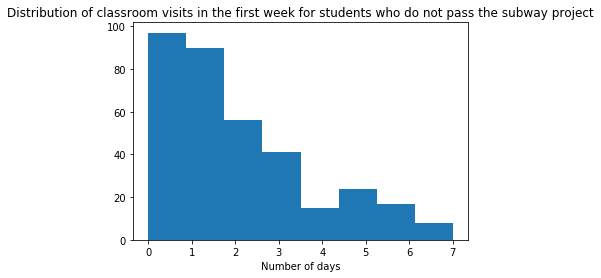

In [38]:
import seaborn as sns

plt.hist(non_passing_visits.values(), bins=8)
plt.xlabel('Number of days')
plt.title('Distribution of classroom visits in the first week ' + 
          'for students who do not pass the subway project')

Text(0.5, 1.0, 'Distribution of classroom visits in the first week for students who pass the subway project')

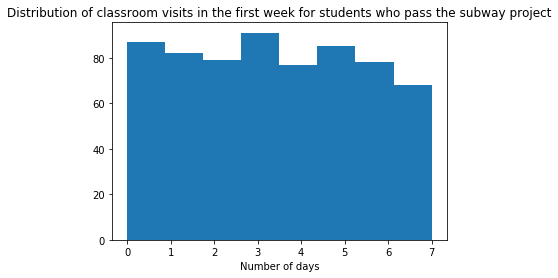

In [39]:
plt.hist(passing_visits.values(), bins=8)
plt.xlabel('Number of days')
plt.title('Distribution of classroom visits in the first week ' + 
          'for students who pass the subway project')